In [1]:
import zipfile
import tensorflow as tf
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
print (session.run(c))

[[22. 28.]
 [49. 64.]]


In [2]:
from keras.layers import *
from keras.models import *
from keras.preprocessing.image import ImageDataGenerator
from keras.losses import *
from keras.optimizers import *
from keras.callbacks import *
from keras.regularizers import *
import time
import pickle
import matplotlib.pyplot as plt
import keras.backend as K
from skimage.io import imread
from skimage.transform import resize

from keras.applications.densenet import DenseNet201, preprocess_input

Using TensorFlow backend.


In [3]:
import os
from keras.preprocessing.image import ImageDataGenerator

batch_size = 16

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

root_path = '/tf/data/Quan/datasets/amazon'
train_generator = train_datagen.flow_from_directory(os.path.join(root_path, 'images'), 
                                                    class_mode='categorical', 
                                                    target_size=(300,300), 
                                                    batch_size=batch_size, 
                                                    shuffle=True)

validation_generator = test_datagen.flow_from_directory(os.path.join(root_path, 'val_images'), 
                                                        class_mode='categorical', 
                                                        target_size=(300,300), 
                                                        batch_size=batch_size, 
                                                        shuffle=False)

test_generator = test_datagen.flow_from_directory(os.path.join(root_path, 'test_images'), 
                                                        class_mode='categorical', 
                                                        target_size=(300,300), 
                                                        batch_size=1, 
                                                        shuffle=False)

label_dict = test_generator.class_indices
print(label_dict)

Found 1576 images belonging to 31 classes.
Found 395 images belonging to 31 classes.
Found 846 images belonging to 31 classes.
{'back_pack': 0, 'bike': 1, 'bike_helmet': 2, 'bookcase': 3, 'bottle': 4, 'calculator': 5, 'desk_chair': 6, 'desk_lamp': 7, 'desktop_computer': 8, 'file_cabinet': 9, 'headphones': 10, 'keyboard': 11, 'laptop_computer': 12, 'letter_tray': 13, 'mobile_phone': 14, 'monitor': 15, 'mouse': 16, 'mug': 17, 'paper_notebook': 18, 'pen': 19, 'phone': 20, 'printer': 21, 'projector': 22, 'punchers': 23, 'ring_binder': 24, 'ruler': 25, 'scissors': 26, 'speaker': 27, 'stapler': 28, 'tape_dispenser': 29, 'trash_can': 30}


In [4]:
import os
from keras.preprocessing.image import ImageDataGenerator

batch_size = 16

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

root_path = '/tf/data/Quan/datasets/webcam'
train_feature_generator = train_datagen.flow_from_directory(os.path.join(root_path, 'images'), 
                                                    class_mode='categorical', 
                                                    target_size=(300,300), 
                                                    batch_size=1, 
                                                    shuffle=False)

validation_feature_generator = test_datagen.flow_from_directory(os.path.join(root_path, 'val_images'), 
                                                        class_mode='categorical', 
                                                        target_size=(300,300), 
                                                        batch_size=1, 
                                                        shuffle=False)

test_feature_generator = test_datagen.flow_from_directory(os.path.join(root_path, 'test_images'), 
                                                        class_mode='categorical', 
                                                        target_size=(300,300), 
                                                        batch_size=1, 
                                                        shuffle=False)

label_dict = test_generator.class_indices
print(label_dict)

Found 444 images belonging to 31 classes.
Found 112 images belonging to 31 classes.
Found 239 images belonging to 31 classes.
{'back_pack': 0, 'bike': 1, 'bike_helmet': 2, 'bookcase': 3, 'bottle': 4, 'calculator': 5, 'desk_chair': 6, 'desk_lamp': 7, 'desktop_computer': 8, 'file_cabinet': 9, 'headphones': 10, 'keyboard': 11, 'laptop_computer': 12, 'letter_tray': 13, 'mobile_phone': 14, 'monitor': 15, 'mouse': 16, 'mug': 17, 'paper_notebook': 18, 'pen': 19, 'phone': 20, 'printer': 21, 'projector': 22, 'punchers': 23, 'ring_binder': 24, 'ruler': 25, 'scissors': 26, 'speaker': 27, 'stapler': 28, 'tape_dispenser': 29, 'trash_can': 30}


In [20]:
baseline_model = load_model('/tf/data/Quan/tf_models/amazon/baseline_model.hdf5')


In [32]:
extractor = Model(baseline_model.inputs, baseline_model.layers[-6].output)
extractor.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv0_block0 (Conv2D)           (None, 300, 300, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batchnorm0_block0 (BatchNormali (None, 300, 300, 32) 128         conv0_block0[0][0]               
__________________________________________________________________________________________________
relu0_block0 (Activation)       (None, 300, 300, 32) 0           batchnorm0_block0[0][0]          
____________________________________________________________________________________________

In [33]:
preds = extractor.predict(test_generator)
np.max(preds)

23.50538

In [21]:
train_feature_generator.reset()
s_train_features = baseline_model.predict_generator(train_feature_generator, verbose=1)
validation_feature_generator.reset()
s_val_features = baseline_model.predict_generator(validation_feature_generator, verbose=1)
test_feature_generator.reset()
s_test_features = baseline_model.predict_generator(test_feature_generator, verbose=1)

239/239 [==============================] - 2s 7ms/step


In [22]:
train_feature_generator.reset()
s_train_labels = np.zeros((444, 31))
for i in range(444):
    s_train_labels[i,:] = train_feature_generator.next()[1]
    
validation_feature_generator.reset()
s_val_labels = np.zeros((112, 31))
for i in range(112):
    s_val_labels[i,:] = validation_feature_generator.next()[1]
    
test_feature_generator.reset()
s_test_labels = np.zeros((239, 31))
for i in range(239):
    s_test_labels[i,:] = test_feature_generator.next()[1]

In [23]:
with open('/tf/data/Quan/tf_models/webcam_playaround/extracted_features.hdf5', 'wb') as dt:
    pickle.dump([s_train_features, s_train_labels], dt)
    
with open('/tf/data/Quan/tf_models/webcam_playaround/val_extracted_features.hdf5', 'wb') as dt:
    pickle.dump([s_val_features, s_val_labels], dt)
    
with open('/tf/data/Quan/tf_models/webcam_playaround/test_extracted_features.hdf5', 'wb') as dt:
    pickle.dump([s_test_features, s_test_labels], dt)

In [4]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(z_mean.shape[1], z_mean.shape[2], z_mean.shape[3]))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def create_vae(input_shape, latent_dim):
    inputs = Input(shape=input_shape, name='encoder_input')

    x = Dense(256)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    z_mean = Dense(latent_dim[-1], name='z_mean')(x)
    z_log_var = Dense(latent_dim[-1], name='z_log_var')(x)

    z = Lambda(sampling, name='z')([z_mean, z_log_var])

    # instantiate encoder model
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()

    # build decoder model
    latent_inputs = Input(shape=(latent_dim), name='z_sampling')

    x = Dense(128)(latent_inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dense(736)(x)
    x = BatchNormalization()(x)
    outputs = Activation('sigmoid')(x)

    # instantiate decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')
    decoder.summary()

    # instantiate VAE model
    outputs = decoder(encoder(inputs)[2])
    
    
    vae = Model(inputs, outputs, name='vae')
    
    reconstruction_loss = binary_crossentropy(inputs, outputs)
#     reconstruction_loss *= 736
    
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    
    return vae

In [5]:
# VAE model = encoder + decoder
# build encoder model

def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(z_mean.shape[1],))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def create_ae(input_shape):
    inputs = Input(shape=input_shape, name='encoder_input')
    _in = Flatten()(inputs)
    
    x = Dense(256)(_in)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    encoder = Model(inputs, x, name='encoder')

    decoder_input = Input(shape=(64,), name='decoder_input')
    x = Dense(128)(decoder_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Dense(input_shape[0]*input_shape[1]*input_shape[2])(x)
    x = BatchNormalization()(x)
#     x = Activation('relu')(x)
    _out = Activation('sigmoid')(x)
    decoder_output = Reshape(input_shape)(_out)

    decoder = Model(decoder_input, decoder_output, name='decoder')
   
    outputs = decoder(encoder(inputs))
    vae = Model(inputs, outputs, name='vae')
    
#     reconstruction_loss = mse(_in, _out)
# #     reconstruction_loss *= (input_shape[0]*input_shape[1]*input_shape[2])
    
# #     kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
# #     kl_loss = K.sum(kl_loss, axis=-1)
# #     kl_loss *= -0.5
    
#     vae_loss = K.mean(reconstruction_loss)
    
#     vae.add_loss(vae_loss)
    vae.compile(loss=binary_crossentropy, optimizer=Adam(0.005))
    
    return vae



In [28]:
ae = create_ae(input_shape=(18,18,736))

In [5]:
with open('/tf/data/Quan/tf_models/amazon/extracted_features.hdf5', 'rb') as dt:
    s_labels, s_features = pickle.load(dt)
    
with open('/tf/data/Quan/tf_models/amazon/val_extracted_features.hdf5', 'rb') as dt:
    sval_labels, sval_features = pickle.load(dt)
    
with open('/tf/data/Quan/tf_models/webcam/extracted_features.hdf5', 'rb') as dt:
    t_labels, t_features = pickle.load(dt)
    
with open('/tf/data/Quan/tf_models/webcam/val_extracted_features.hdf5', 'rb') as dt:
    tval_labels, tval_features = pickle.load(dt)

with open('/tf/data/Quan/tf_models/webcam/t_test_features.hdf5', 'rb') as dt:
    ttest_labels, ttest_features = pickle.load(dt)

# s_labels = [k.split('/')[-2] for k in s_labels]
# sval_labels = [k.split('/')[-2] for k in sval_labels]

t_labels = [k.split('/')[-2] for k in t_labels]
tval_labels = [k.split('/')[-2] for k in tval_labels]
    
# s_features.shape, sval_features.shape, t_features.shape

In [6]:
s_features /= np.max(s_features)
sval_features /= np.max(sval_features)
t_features /= np.max(t_features)
tval_features /= np.max(tval_features)
ttest_features /= np.max(ttest_features)

In [17]:
datagen = ImageDataGenerator()

s_train_generator = datagen.flow(s_features, None, batch_size=32)
s_val_generator = datagen.flow(sval_features, None, batch_size=32)
t_train_generator = datagen.flow(t_features, None, batch_size=32)
t_val_generator = datagen.flow(tval_features, None, batch_size=32)
t_test_generator = datagen.flow(ttest_features, None, batch_size=32)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1576, 18, 18, 736) (736 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (395, 18, 18, 736) (736 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either

## Amazon

In [13]:
np.min(s_features)

0.0

In [10]:
# VANILLA AE
vae = create_ae(input_shape=(18,18,736))

batch_size=32
mcp = ModelCheckpoint('/tf/data/Quan/tf_models/amazon_playaround/ae_model_weights.hdf5', monitor='val_loss', 
                      save_best_only=True, save_weights_only=True)

start = time.time()
history = vae.fit_generator(s_train_generator, epochs=100, 
          validation_data=s_val_generator, callbacks=[mcp], verbose=1)

exe_time = time.time() - start

print('exe time: ', exe_time)
with open('/tf/data/Quan/tf_models/amazon_playaround/ae_history.hdf5', 'wb') as dt:
    pickle.dump(history.history, dt)
    

Epoch 1/100
50/50 [==============================] - 5s 103ms/step - loss: 0.6719 - val_loss: 0.6127
Epoch 2/100
50/50 [==============================] - 4s 82ms/step - loss: 0.5728 - val_loss: 0.5331
Epoch 3/100
50/50 [==============================] - 4s 79ms/step - loss: 0.4991 - val_loss: 0.4642
Epoch 4/100
50/50 [==============================] - 4s 80ms/step - loss: 0.4367 - val_loss: 0.4090
Epoch 5/100
50/50 [==============================] - 4s 81ms/step - loss: 0.3849 - val_loss: 0.3618
Epoch 6/100
50/50 [==============================] - 4s 80ms/step - loss: 0.3423 - val_loss: 0.3244
Epoch 7/100
50/50 [==============================] - 4s 80ms/step - loss: 0.3072 - val_loss: 0.2950
Epoch 8/100
50/50 [==============================] - 4s 78ms/step - loss: 0.2781 - val_loss: 0.2637
Epoch 9/100
50/50 [==============================] - 4s 80ms/step - loss: 0.2542 - val_loss: 0.2439
Epoch 10/100
50/50 [==============================] - 4s 77ms/step - loss: 0.2343 - val_loss: 0.227

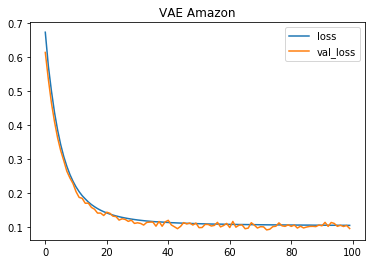

In [11]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('AE Amazon')
plt.show()

In [7]:
# VAE
vae = create_vae(input_shape=(18,18,736), latent_dim=(18,18,64))

batch_size=32
mcp = ModelCheckpoint('/tf/data/Quan/tf_models/amazon_playaround/vae_model_weights.hdf5', monitor='val_loss', 
                      save_best_only=True, save_weights_only=True)

start = time.time()
history = vae.fit(s_features, epochs=100, 
          validation_data=(sval_features, None), callbacks=[mcp], verbose=1)

exe_time = time.time() - start

print('exe time: ', exe_time)
with open('/tf/data/Quan/tf_models/amazon_playaround/vae_history.hdf5', 'wb') as dt:
    pickle.dump(history.history, dt)
    

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 18, 18, 736)  0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 18, 18, 256)  188672      encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 18, 18, 256)  1024        dense_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 18, 18, 256)  0           batch_normalization_1[0][0]      
___________

/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))



Train on 1576 samples, validate on 395 samples
Epoch 1/100
1576/1576 [==============================] - 3s 2ms/step - loss: 7.0292 - val_loss: 1.0790
Epoch 2/100
1576/1576 [==============================] - 2s 1ms/step - loss: 1.2793 - val_loss: 1.0581
Epoch 3/100
1576/1576 [==============================] - 2s 1ms/step - loss: 0.9719 - val_loss: 0.8280
Epoch 4/100
1576/1576 [==============================] - 2s 1ms/step - loss: 0.8457 - val_loss: 0.7607
Epoch 5/100
1576/1576 [==============================] - 2s 1ms/step - loss: 0.7710 - val_loss: 0.6858
Epoch 6/100
1576/1576 [==============================] - 2s 1ms/step - loss: 0.7180 - val_loss: 0.6543
Epoch 7/100
1576/1576 [==============================] - 2s 1ms/step - loss: 0.6732 - val_loss: 0.6101
Epoch 8/100
1576/1576 [==============================] - 2s 1ms/step - loss: 0.6383 - val_loss: 0.5842
Epoch 9/100
1576/1576 [==============================] - 2s 1ms/step - loss: 0.6065 - val_loss: 0.5608
Epoch 10/100
1576/1576 [=

1576/1576 [==============================] - 2s 1ms/step - loss: 0.1453 - val_loss: 0.1415
Epoch 78/100
1576/1576 [==============================] - 2s 1ms/step - loss: 0.1441 - val_loss: 0.1405
Epoch 79/100
1576/1576 [==============================] - 2s 1ms/step - loss: 0.1430 - val_loss: 0.1395
Epoch 80/100
1576/1576 [==============================] - 2s 1ms/step - loss: 0.1420 - val_loss: 0.1383
Epoch 81/100
1576/1576 [==============================] - 2s 1ms/step - loss: 0.1409 - val_loss: 0.1373
Epoch 82/100
1576/1576 [==============================] - 2s 1ms/step - loss: 0.1400 - val_loss: 0.1363
Epoch 83/100
1576/1576 [==============================] - 2s 989us/step - loss: 0.1391 - val_loss: 0.1358
Epoch 84/100
1576/1576 [==============================] - 2s 1ms/step - loss: 0.1382 - val_loss: 0.1348
Epoch 85/100
1576/1576 [==============================] - 2s 983us/step - loss: 0.1373 - val_loss: 0.1339
Epoch 86/100
1576/1576 [==============================] - 2s 1ms/step - l

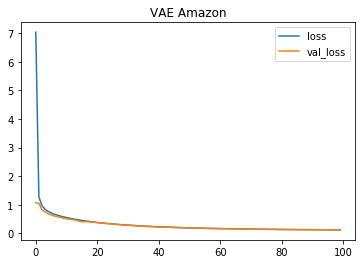

In [8]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('VAE Amazon')
plt.show()

## Webcam

In [9]:
vae = create_ae(input_shape=(18,18,736))

batch_size=16
mcp = ModelCheckpoint('/tf/data/Quan/tf_models/webcam_playaround/ae_model_weights.hdf5', monitor='val_loss', 
                      save_best_only=True, save_weights_only=True)

start = time.time()
history = vae.fit_generator(t_train_generator, epochs=100, 
          validation_data=t_val_generator, callbacks=[mcp], verbose=1)

exe_time = time.time() - start

print('exe time: ', exe_time)
with open('/tf/data/Quan/tf_models/webcam_playaround/ae_history.hdf5', 'wb') as dt:
    pickle.dump(history.history, dt)
    

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/100
14/14 [==============================] - 2s 148ms/step - loss: 0.7277 - val_loss: 0.6723
Epoch 2/100
14/14 [==============================] - 1s 74ms/step - loss: 0.6798 - val_loss: 0.6654
Epoch 3/100
14/14 [==============================] - 1s 76ms/step - loss: 0.6436 - val_loss: 0.6323
Epoch 4/100
14/14 [==============================] - 1s 75ms/step - loss: 0.6168 - val_loss: 0.6030
Epoch 5/100
14/14 [==============================] - 1s 77ms/step - loss: 0.5929 - val_loss: 0.5831
Epoch 6/100
14/14 [==============================] - 1s 77ms/step - loss: 0.5701 - val_loss: 0.5617
Epoch 7/100
14/14 [==============================] - 1s 75ms/step - loss: 0.5487 - val_loss: 0.5401
Epoch 8/100
14/14 [==============================] - 1s 76ms/step - loss: 0.5282 - val_loss: 0.5195
Epoch 9/100
14/14 [====

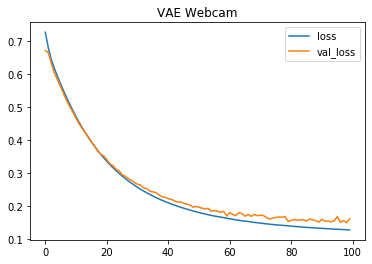

In [10]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('VAE Webcam')
plt.show()

In [9]:
# VAE
vae = create_vae(input_shape=(18,18,736), latent_dim=(18,18,64))

batch_size=32
mcp = ModelCheckpoint('/tf/data/Quan/tf_models/webcam_playaround/vae_model_weights.hdf5', monitor='val_loss', 
                      save_best_only=True, save_weights_only=True)

start = time.time()
history = vae.fit(t_features, epochs=100, 
          validation_data=(tval_features, None), callbacks=[mcp], verbose=1)

exe_time = time.time() - start

print('exe time: ', exe_time)
with open('/tf/data/Quan/tf_models/webcam_playaround/vae_history.hdf5', 'wb') as dt:
    pickle.dump(history.history, dt)
    

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 18, 18, 736)  0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 18, 18, 256)  188672      encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 18, 18, 256)  1024        dense_6[0][0]                    
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 18, 18, 256)  0           batch_normalization_6[0][0]      
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 444 samples, validate on 112 samples
Epoch 1/100
444/444 [==============================] - 1s 3ms/step - loss: 17.1668 - val_loss: 0.9025
Epoch 2/100
444/444 [==============================] - 0s 1ms/step - loss: 4.9867 - val_loss: 1.1870
Epoch 3/100
444/444 [==============================] - 1s 1ms/step - loss: 2.5723 - val_loss: 1.3656
Epoch 4/100
444/444 [==============================] - 0s 1ms/step - loss: 1.6908 - val_loss: 1.2988
Epoch 5/100
444/444 [==============================] - 1s 1ms/step - loss: 1.2955 - val_loss: 1.1843
Epoch 6/100
444/444 [==============================] - 1s 1ms/step - loss: 1.1162 - val_loss: 1.0217
Epoch 7/100
444/444 [==============================] - 0s 1ms/step - loss: 1.0040 - val_loss: 0.9514
Epoch 8/100
444/444 [==============================] - 0s 1ms/step - loss: 0.9382 - val_loss: 0.9518
Epoch 9/100
444/444 [==============================] - 0s 1ms/step - loss: 0.8937 - val_loss: 0.8552
Epoch 10/100
444/444 [======================

Epoch 81/100
444/444 [==============================] - 1s 1ms/step - loss: 0.3583 - val_loss: 0.3687
Epoch 82/100
444/444 [==============================] - 0s 1ms/step - loss: 0.3555 - val_loss: 0.3666
Epoch 83/100
444/444 [==============================] - 0s 1ms/step - loss: 0.3526 - val_loss: 0.3610
Epoch 84/100
444/444 [==============================] - 1s 1ms/step - loss: 0.3499 - val_loss: 0.3608
Epoch 85/100
444/444 [==============================] - 0s 1ms/step - loss: 0.3471 - val_loss: 0.3580
Epoch 86/100
444/444 [==============================] - 0s 1ms/step - loss: 0.3444 - val_loss: 0.3548
Epoch 87/100
444/444 [==============================] - 0s 1ms/step - loss: 0.3418 - val_loss: 0.3502
Epoch 88/100
444/444 [==============================] - 0s 1ms/step - loss: 0.3393 - val_loss: 0.3478
Epoch 89/100
444/444 [==============================] - 0s 1ms/step - loss: 0.3367 - val_loss: 0.3473
Epoch 90/100
444/444 [==============================] - 0s 1ms/step - loss: 0.3341

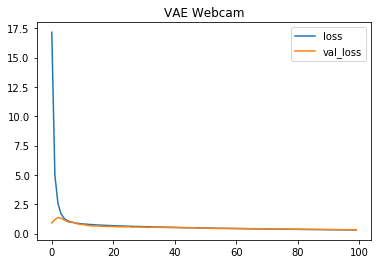

In [10]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('VAE Webcam')
plt.show()

## Combine VAE

In [12]:
import keras.losses

# latent_dim = latent_dim = (18,18,64)

s_vae = create_vae(input_shape=(18,18,736), latent_dim=(18,18,64))
s_vae.load_weights('/tf/data/Quan/tf_models/amazon_playaround/vae_model_weights.hdf5')
t_vae = create_vae(input_shape=(18,18,736), latent_dim=(18,18,64))
t_vae.load_weights('/tf/data/Quan/tf_models/webcam_playaround/vae_model_weights.hdf5')


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 18, 18, 736)  0                                            
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 18, 18, 256)  188672      encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 18, 18, 256)  1024        dense_11[0][0]                   
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 18, 18, 256)  0           batch_normalization_11[0][0]     
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 18, 18, 736)  0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 18, 18, 256)  188672      encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 18, 18, 256)  1024        dense_16[0][0]                   
__________________________________________________________________________________________________
activation_16 (Activation)      (None, 18, 18, 256)  0           batch_normalization_16[0][0]     
____________________________________________________________________________________________

In [13]:
t_encoder = Model(t_vae.get_layer('encoder').inputs, t_vae.get_layer('encoder').outputs, name='t_encoder')
s_decoder = Model(s_vae.get_layer('decoder').inputs, s_vae.get_layer('decoder').outputs, name='s_decoder')

In [15]:
c_vae_outputs = s_decoder(t_encoder(t_encoder.inputs)[2])
c_vae = Model(t_encoder.inputs, c_vae_outputs, name='combined_vae')
c_vae.summary()

Model: "combined_vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 18, 18, 736)       0         
_________________________________________________________________
t_encoder (Model)            [(None, 18, 18, 64), (Non 239616    
_________________________________________________________________
s_decoder (Model)            (None, 18, 18, 736)       234976    
Total params: 474,592
Trainable params: 471,584
Non-trainable params: 3,008
_________________________________________________________________


In [16]:
t_num_labels = [label_dict[k] for k in t_labels]
tval_num_labels = [label_dict[k] for k in tval_labels]
ttest_num_labels = [label_dict[k] for k in ttest_labels]

t_num_labels = keras.utils.to_categorical(t_num_labels, 31)
tval_num_labels = keras.utils.to_categorical(tval_num_labels, 31)
ttest_num_labels = keras.utils.to_categorical(ttest_num_labels, 31)

transform_features = c_vae.predict(t_features, verbose=1)
val_transform_features = c_vae.predict(tval_features, verbose=1)
test_transform_features = c_vae.predict(ttest_features, verbose=1)

239/239 [==============================] - 0s 902us/step


In [19]:
datagen = ImageDataGenerator()
transform_train_generator = datagen.flow(transform_features, t_num_labels, batch_size=32)
transform_val_generator = datagen.flow(val_transform_features, tval_num_labels, batch_size=32)
# transform_test_generator = datagen.flow(val_transform_features, tval_num_labels)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (444, 18, 18, 736) (736 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (112, 18, 18, 736) (736 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [34]:
transform_train_generator = datagen.flow(t_features, t_num_labels, batch_size=32)
transform_val_generator = datagen.flow(tval_features, tval_num_labels, batch_size=32)
# transform_test_generator = datagen.flow(val_transform_features, tval_num_labels)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (444, 18, 18, 736) (736 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (112, 18, 18, 736) (736 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [46]:
baseline_model = load_model('/tf/data/Quan/tf_models/amazon/baseline_model.hdf5')

In [27]:
# retrain source classifier
c_vae.trainable=False

input_model = Input(shape=(18,18,736))

# add combined vae
t = c_vae(input_model)
residual = Add()([t, input_model])
x = BatchNormalization()(residual)
x = Activation('relu')(x)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(31)(x)
x = BatchNormalization()(x)
x = Activation('softmax')(x)

s_topmodel = Model(input_model, x)

s_topmodel.compile(loss='categorical_crossentropy', optimizer=Adam(0.0005), metrics=['accuracy'])

s_topmodel.layers[-2].set_weights(baseline_model.layers[-2].get_weights())
s_topmodel.layers[-3].set_weights(baseline_model.layers[-3].get_weights())

s_topmodel.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 18, 18, 736)  0                                            
__________________________________________________________________________________________________
combined_vae (Model)            (None, 18, 18, 736)  123371968   input_3[0][0]                    
__________________________________________________________________________________________________
add_1 (Add)                     (None, 18, 18, 736)  0           combined_vae[1][0]               
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 18, 18, 736)  2944        add_1[0][0]                

In [17]:
baseline_model = load_model('/tf/data/Quan/tf_models/amazon/baseline_model.hdf5')

# retrain source classifier

input_model = Input(shape=(18,18,736))
x = GlobalAveragePooling2D()(input_model)
x = Dropout(0.3)(x)
x = Dense(31)(x)
x = BatchNormalization()(x)
x = Activation('softmax')(x)

s_topmodel = Model(input_model, x)

s_topmodel.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

s_topmodel.layers[-2].set_weights(baseline_model.layers[-2].get_weights())
s_topmodel.layers[-3].set_weights(baseline_model.layers[-3].get_weights())

s_topmodel.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 18, 18, 736)       0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 736)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 736)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 31)                22847     
_________________________________________________________________
batch_normalization_21 (Batc (None, 31)                124       
_________________________________________________________________
activation_21 (Activation)   (None, 31)                0         
Total params: 22,971
Trainable params: 22,909
Non-trainable params: 62
_____________________________________________________

### VAE

In [20]:
mcp = ModelCheckpoint('/tf/data/Quan/tf_models/webcam_playaround/amazon_vae_model.hdf5', monitor='val_accuracy', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = s_topmodel.fit_generator(transform_train_generator, epochs=200,
               validation_data=transform_val_generator, verbose=1, callbacks=[mcp])
    
exe_time = time.time() - start
history.history['exe_time'] = exe_time

with open('/tf/data/Quan/tf_models/webcam_playaround/amazon_vae_history.hdf5', 'wb') as dt:
    pickle.dump(history, dt)

print('exe time: ', exe_time)

Epoch 1/200
14/14 [==============================] - 1s 41ms/step - loss: 4.7688 - accuracy: 0.0225 - val_loss: 3.8887 - val_accuracy: 0.0179
Epoch 2/200
14/14 [==============================] - 0s 13ms/step - loss: 4.7914 - accuracy: 0.0270 - val_loss: 3.5211 - val_accuracy: 0.0179
Epoch 3/200
14/14 [==============================] - 0s 15ms/step - loss: 4.5364 - accuracy: 0.0450 - val_loss: 3.8356 - val_accuracy: 0.0179
Epoch 4/200
14/14 [==============================] - 0s 18ms/step - loss: 4.6844 - accuracy: 0.0225 - val_loss: 3.7163 - val_accuracy: 0.0179
Epoch 5/200
14/14 [==============================] - 0s 19ms/step - loss: 4.4154 - accuracy: 0.0383 - val_loss: 3.8249 - val_accuracy: 0.0179
Epoch 6/200
14/14 [==============================] - 0s 19ms/step - loss: 4.5810 - accuracy: 0.0338 - val_loss: 3.6927 - val_accuracy: 0.0179
Epoch 7/200
14/14 [==============================] - 0s 19ms/step - loss: 4.6539 - accuracy: 0.0270 - val_loss: 3.5277 - val_accuracy: 0.0179
Epoch 

14/14 [==============================] - 0s 20ms/step - loss: 4.0748 - accuracy: 0.0338 - val_loss: 3.4520 - val_accuracy: 0.0089
Epoch 59/200
14/14 [==============================] - 0s 19ms/step - loss: 3.8942 - accuracy: 0.0608 - val_loss: 3.4046 - val_accuracy: 0.0089
Epoch 60/200
14/14 [==============================] - 0s 21ms/step - loss: 3.9081 - accuracy: 0.0405 - val_loss: 3.4448 - val_accuracy: 0.0089
Epoch 61/200
14/14 [==============================] - 0s 16ms/step - loss: 3.9705 - accuracy: 0.0225 - val_loss: 3.4463 - val_accuracy: 0.0982
Epoch 62/200
14/14 [==============================] - 0s 18ms/step - loss: 4.0489 - accuracy: 0.0315 - val_loss: 3.5324 - val_accuracy: 0.0625
Epoch 63/200
14/14 [==============================] - 0s 20ms/step - loss: 4.0741 - accuracy: 0.0315 - val_loss: 3.5146 - val_accuracy: 0.0357
Epoch 64/200
14/14 [==============================] - 0s 18ms/step - loss: 3.9936 - accuracy: 0.0293 - val_loss: 3.4966 - val_accuracy: 0.0357
Epoch 65/200

14/14 [==============================] - 0s 19ms/step - loss: 3.6354 - accuracy: 0.0338 - val_loss: 3.5055 - val_accuracy: 0.0357
Epoch 116/200
14/14 [==============================] - 0s 22ms/step - loss: 3.5739 - accuracy: 0.0495 - val_loss: 3.5035 - val_accuracy: 0.0357
Epoch 117/200
14/14 [==============================] - 0s 17ms/step - loss: 3.6225 - accuracy: 0.0360 - val_loss: 3.3830 - val_accuracy: 0.0357
Epoch 118/200
14/14 [==============================] - 0s 19ms/step - loss: 3.6550 - accuracy: 0.0338 - val_loss: 3.4343 - val_accuracy: 0.0357
Epoch 119/200
14/14 [==============================] - 0s 19ms/step - loss: 3.6489 - accuracy: 0.0338 - val_loss: 3.4961 - val_accuracy: 0.0357
Epoch 120/200
14/14 [==============================] - 0s 19ms/step - loss: 3.5878 - accuracy: 0.0473 - val_loss: 3.3913 - val_accuracy: 0.0357
Epoch 121/200
14/14 [==============================] - 0s 22ms/step - loss: 3.5970 - accuracy: 0.0383 - val_loss: 3.4188 - val_accuracy: 0.0357
Epoch 

Epoch 172/200
14/14 [==============================] - 0s 19ms/step - loss: 3.4632 - accuracy: 0.0495 - val_loss: 3.2887 - val_accuracy: 0.0357
Epoch 173/200
14/14 [==============================] - 0s 17ms/step - loss: 3.4705 - accuracy: 0.0495 - val_loss: 3.5896 - val_accuracy: 0.0357
Epoch 174/200
14/14 [==============================] - 0s 18ms/step - loss: 3.4395 - accuracy: 0.0473 - val_loss: 3.4741 - val_accuracy: 0.0357
Epoch 175/200
14/14 [==============================] - 0s 21ms/step - loss: 3.4649 - accuracy: 0.0495 - val_loss: 3.3915 - val_accuracy: 0.0357
Epoch 176/200
14/14 [==============================] - 0s 19ms/step - loss: 3.4716 - accuracy: 0.0541 - val_loss: 3.4544 - val_accuracy: 0.0357
Epoch 177/200
14/14 [==============================] - 0s 17ms/step - loss: 3.4358 - accuracy: 0.0563 - val_loss: 3.4276 - val_accuracy: 0.0357
Epoch 178/200
14/14 [==============================] - 0s 17ms/step - loss: 3.4722 - accuracy: 0.0495 - val_loss: 3.4788 - val_accuracy:

### Vanilla AE

In [35]:
mcp = ModelCheckpoint('/tf/data/Quan/tf_models/webcam_playaround/amazon_extractor_model.hdf5', monitor='val_accuracy', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = s_topmodel.fit_generator(transform_train_generator, epochs=200,
               validation_data=transform_val_generator, verbose=1, callbacks=[mcp])
    
exe_time = time.time() - start
history.history['exe_time'] = exe_time

with open('/tf/data/Quan/tf_models/webcam_playaround/amazon_extractor_history.hdf5', 'wb') as dt:
    pickle.dump(history, dt)

print('exe time: ', exe_time)

Epoch 1/200
14/14 [==============================] - 1s 66ms/step - loss: 3.9162 - accuracy: 0.0721 - val_loss: 4.0504 - val_accuracy: 0.0268
Epoch 2/200
14/14 [==============================] - 0s 13ms/step - loss: 3.0168 - accuracy: 0.2117 - val_loss: 3.8631 - val_accuracy: 0.0714
Epoch 3/200
14/14 [==============================] - 0s 14ms/step - loss: 2.3742 - accuracy: 0.3378 - val_loss: 3.5844 - val_accuracy: 0.0804
Epoch 4/200
14/14 [==============================] - 0s 16ms/step - loss: 1.9824 - accuracy: 0.4505 - val_loss: 3.4689 - val_accuracy: 0.0804
Epoch 5/200
14/14 [==============================] - 0s 15ms/step - loss: 1.5346 - accuracy: 0.5968 - val_loss: 3.4477 - val_accuracy: 0.0982
Epoch 6/200
14/14 [==============================] - 0s 18ms/step - loss: 1.3381 - accuracy: 0.6396 - val_loss: 3.2487 - val_accuracy: 0.1071
Epoch 7/200
14/14 [==============================] - 0s 14ms/step - loss: 1.1417 - accuracy: 0.6982 - val_loss: 3.2588 - val_accuracy: 0.1161
Epoch 

14/14 [==============================] - 0s 19ms/step - loss: 0.2006 - accuracy: 0.9730 - val_loss: 0.6808 - val_accuracy: 0.8839
Epoch 116/200
14/14 [==============================] - 0s 15ms/step - loss: 0.1877 - accuracy: 0.9865 - val_loss: 0.5698 - val_accuracy: 0.8839
Epoch 117/200
14/14 [==============================] - 0s 18ms/step - loss: 0.1682 - accuracy: 0.9820 - val_loss: 0.1818 - val_accuracy: 0.8929
Epoch 118/200
14/14 [==============================] - 0s 16ms/step - loss: 0.1525 - accuracy: 0.9887 - val_loss: 0.4652 - val_accuracy: 0.8839
Epoch 119/200
14/14 [==============================] - 0s 16ms/step - loss: 0.1785 - accuracy: 0.9865 - val_loss: 0.2501 - val_accuracy: 0.8929
Epoch 120/200
14/14 [==============================] - 0s 17ms/step - loss: 0.1686 - accuracy: 0.9820 - val_loss: 0.2779 - val_accuracy: 0.8839
Epoch 121/200
14/14 [==============================] - 0s 16ms/step - loss: 0.1861 - accuracy: 0.9752 - val_loss: 0.2333 - val_accuracy: 0.8839
Epoch 

Epoch 172/200
14/14 [==============================] - 0s 15ms/step - loss: 0.1445 - accuracy: 0.9842 - val_loss: 0.1087 - val_accuracy: 0.8839
Epoch 173/200
14/14 [==============================] - 0s 16ms/step - loss: 0.1490 - accuracy: 0.9910 - val_loss: 0.6033 - val_accuracy: 0.8839
Epoch 174/200
14/14 [==============================] - 0s 18ms/step - loss: 0.1339 - accuracy: 0.9977 - val_loss: 0.1710 - val_accuracy: 0.8839
Epoch 175/200
14/14 [==============================] - 0s 16ms/step - loss: 0.1440 - accuracy: 0.9887 - val_loss: 0.1849 - val_accuracy: 0.8839
Epoch 176/200
14/14 [==============================] - 0s 15ms/step - loss: 0.1243 - accuracy: 0.9910 - val_loss: 0.3287 - val_accuracy: 0.8839
Epoch 177/200
14/14 [==============================] - 0s 19ms/step - loss: 0.1301 - accuracy: 0.9932 - val_loss: 0.5907 - val_accuracy: 0.8839
Epoch 178/200
14/14 [==============================] - 0s 18ms/step - loss: 0.1586 - accuracy: 0.9820 - val_loss: 0.3418 - val_accuracy:

In [29]:
mcp = ModelCheckpoint('/tf/data/Quan/tf_models/webcam_playaround/amazon_ae_residual_model.hdf5', monitor='val_accuracy', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = s_topmodel.fit_generator(transform_train_generator, epochs=200,
               validation_data=transform_val_generator, verbose=1, callbacks=[mcp])
    
exe_time = time.time() - start
history.history['exe_time'] = exe_time

with open('/tf/data/Quan/tf_models/webcam_playaround/amazon_ae_residual_history.hdf5', 'wb') as dt:
    pickle.dump(history, dt)

print('exe time: ', exe_time)

Epoch 1/200
14/14 [==============================] - 2s 124ms/step - loss: 3.9594 - accuracy: 0.0631 - val_loss: 3.7923 - val_accuracy: 0.0804
Epoch 2/200
14/14 [==============================] - 0s 23ms/step - loss: 3.0138 - accuracy: 0.2005 - val_loss: 3.6070 - val_accuracy: 0.0804
Epoch 3/200
14/14 [==============================] - 0s 20ms/step - loss: 2.2761 - accuracy: 0.3581 - val_loss: 3.9271 - val_accuracy: 0.0804
Epoch 4/200
14/14 [==============================] - 0s 22ms/step - loss: 1.7656 - accuracy: 0.4662 - val_loss: 3.3444 - val_accuracy: 0.0804
Epoch 5/200
14/14 [==============================] - 0s 21ms/step - loss: 1.5113 - accuracy: 0.5856 - val_loss: 3.5536 - val_accuracy: 0.0714
Epoch 6/200
14/14 [==============================] - 0s 23ms/step - loss: 1.2738 - accuracy: 0.6824 - val_loss: 4.0200 - val_accuracy: 0.0714
Epoch 7/200
14/14 [==============================] - 0s 21ms/step - loss: 1.1617 - accuracy: 0.6914 - val_loss: 3.7554 - val_accuracy: 0.0714
Epoch

14/14 [==============================] - 0s 20ms/step - loss: 0.1733 - accuracy: 0.9887 - val_loss: 0.6930 - val_accuracy: 0.8661
Epoch 116/200
14/14 [==============================] - 0s 27ms/step - loss: 0.2149 - accuracy: 0.9685 - val_loss: 0.2848 - val_accuracy: 0.8661
Epoch 117/200
14/14 [==============================] - 0s 25ms/step - loss: 0.1925 - accuracy: 0.9707 - val_loss: 0.4102 - val_accuracy: 0.8661
Epoch 118/200
14/14 [==============================] - 0s 20ms/step - loss: 0.1912 - accuracy: 0.9730 - val_loss: 0.7895 - val_accuracy: 0.8661
Epoch 119/200
14/14 [==============================] - 0s 21ms/step - loss: 0.1822 - accuracy: 0.9730 - val_loss: 0.2361 - val_accuracy: 0.8571
Epoch 120/200
14/14 [==============================] - 0s 20ms/step - loss: 0.1889 - accuracy: 0.9752 - val_loss: 0.7922 - val_accuracy: 0.8571
Epoch 121/200
14/14 [==============================] - 0s 20ms/step - loss: 0.1975 - accuracy: 0.9617 - val_loss: 0.3677 - val_accuracy: 0.8571
Epoch 

Epoch 172/200
14/14 [==============================] - 0s 22ms/step - loss: 0.1416 - accuracy: 0.9797 - val_loss: 0.8314 - val_accuracy: 0.8571
Epoch 173/200
14/14 [==============================] - 0s 21ms/step - loss: 0.1476 - accuracy: 0.9820 - val_loss: 0.3722 - val_accuracy: 0.8571
Epoch 174/200
14/14 [==============================] - 0s 26ms/step - loss: 0.1557 - accuracy: 0.9797 - val_loss: 0.4952 - val_accuracy: 0.8482
Epoch 175/200
14/14 [==============================] - 0s 20ms/step - loss: 0.1577 - accuracy: 0.9842 - val_loss: 0.6126 - val_accuracy: 0.8482
Epoch 176/200
14/14 [==============================] - 0s 20ms/step - loss: 0.1404 - accuracy: 0.9910 - val_loss: 0.6181 - val_accuracy: 0.8482
Epoch 177/200
14/14 [==============================] - 0s 21ms/step - loss: 0.1622 - accuracy: 0.9865 - val_loss: 0.3417 - val_accuracy: 0.8482
Epoch 178/200
14/14 [==============================] - 0s 20ms/step - loss: 0.1742 - accuracy: 0.9842 - val_loss: 0.4038 - val_accuracy:

In [24]:
mcp = ModelCheckpoint('/tf/data/Quan/tf_models/webcam_playaround/amazon_ae_model.hdf5', monitor='val_accuracy', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = s_topmodel.fit_generator(transform_train_generator, epochs=200,
               validation_data=transform_val_generator, verbose=1, callbacks=[mcp])
    
exe_time = time.time() - start
history.history['exe_time'] = exe_time

with open('/tf/data/Quan/tf_models/webcam_playaround/amazon_ae_history.hdf5', 'wb') as dt:
    pickle.dump(history, dt)

print('exe time: ', exe_time)

Epoch 1/200
14/14 [==============================] - 1s 47ms/step - loss: 4.2175 - accuracy: 0.0338 - val_loss: 3.7598 - val_accuracy: 0.0179
Epoch 2/200
14/14 [==============================] - 0s 12ms/step - loss: 3.9791 - accuracy: 0.0608 - val_loss: 3.6870 - val_accuracy: 0.0179
Epoch 3/200
14/14 [==============================] - 0s 16ms/step - loss: 3.8046 - accuracy: 0.0653 - val_loss: 3.7231 - val_accuracy: 0.0179
Epoch 4/200
14/14 [==============================] - 0s 15ms/step - loss: 3.6596 - accuracy: 0.0788 - val_loss: 3.9779 - val_accuracy: 0.0268
Epoch 5/200
14/14 [==============================] - 0s 22ms/step - loss: 3.5100 - accuracy: 0.1036 - val_loss: 3.2469 - val_accuracy: 0.0357
Epoch 6/200
14/14 [==============================] - 0s 15ms/step - loss: 3.3807 - accuracy: 0.1149 - val_loss: 3.3649 - val_accuracy: 0.0714
Epoch 7/200
14/14 [==============================] - 0s 18ms/step - loss: 3.1180 - accuracy: 0.1577 - val_loss: 3.6422 - val_accuracy: 0.0714
Epoch 

14/14 [==============================] - 0s 16ms/step - loss: 1.3758 - accuracy: 0.6194 - val_loss: 1.6185 - val_accuracy: 0.6429
Epoch 116/200
14/14 [==============================] - 0s 20ms/step - loss: 1.4235 - accuracy: 0.6081 - val_loss: 1.4657 - val_accuracy: 0.6518
Epoch 117/200
14/14 [==============================] - 0s 16ms/step - loss: 1.4466 - accuracy: 0.5923 - val_loss: 1.2738 - val_accuracy: 0.6696
Epoch 118/200
14/14 [==============================] - 0s 17ms/step - loss: 1.3840 - accuracy: 0.6149 - val_loss: 1.7448 - val_accuracy: 0.6696
Epoch 119/200
14/14 [==============================] - 0s 17ms/step - loss: 1.4063 - accuracy: 0.6104 - val_loss: 1.1223 - val_accuracy: 0.6696
Epoch 120/200
14/14 [==============================] - 0s 19ms/step - loss: 1.4303 - accuracy: 0.6126 - val_loss: 1.5026 - val_accuracy: 0.6786
Epoch 121/200
14/14 [==============================] - 0s 18ms/step - loss: 1.4109 - accuracy: 0.5946 - val_loss: 0.9068 - val_accuracy: 0.6786
Epoch 

Epoch 172/200
14/14 [==============================] - 0s 18ms/step - loss: 1.2896 - accuracy: 0.6847 - val_loss: 1.3777 - val_accuracy: 0.6964
Epoch 173/200
14/14 [==============================] - 0s 15ms/step - loss: 1.2533 - accuracy: 0.6959 - val_loss: 1.3813 - val_accuracy: 0.7143
Epoch 174/200
14/14 [==============================] - 0s 19ms/step - loss: 1.2654 - accuracy: 0.6306 - val_loss: 1.1662 - val_accuracy: 0.7054
Epoch 175/200
14/14 [==============================] - 0s 17ms/step - loss: 1.3026 - accuracy: 0.6329 - val_loss: 1.5375 - val_accuracy: 0.7054
Epoch 176/200
14/14 [==============================] - 0s 15ms/step - loss: 1.2672 - accuracy: 0.6486 - val_loss: 1.4180 - val_accuracy: 0.7143
Epoch 177/200
14/14 [==============================] - 0s 19ms/step - loss: 1.2527 - accuracy: 0.6667 - val_loss: 1.4674 - val_accuracy: 0.7054
Epoch 178/200
14/14 [==============================] - 0s 19ms/step - loss: 1.2647 - accuracy: 0.6419 - val_loss: 1.0355 - val_accuracy:

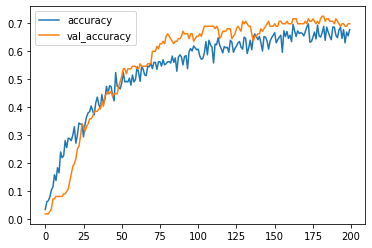

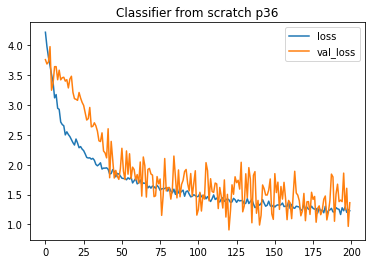

In [25]:
%matplotlib inline
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.title('Classifier from scratch p36')
plt.show()

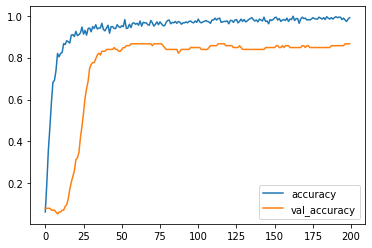

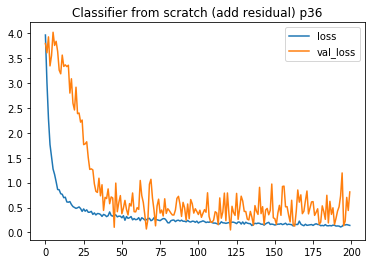

In [30]:
%matplotlib inline
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.title('Classifier from scratch (add residual) p36')
plt.show()

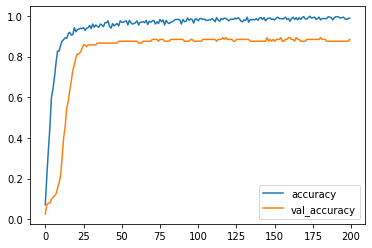

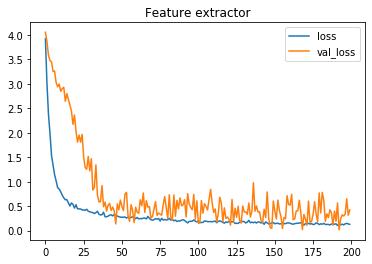

In [36]:
%matplotlib inline
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.title('Feature extractor')
plt.show()

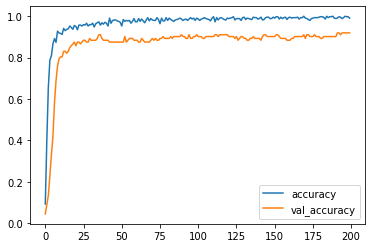

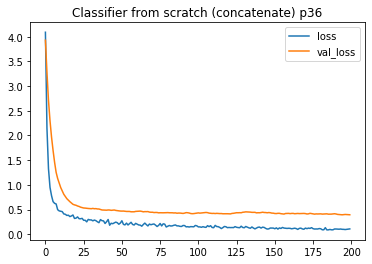

In [23]:
%matplotlib inline
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.title('Classifier from scratch (concatenate) p36')
plt.show()

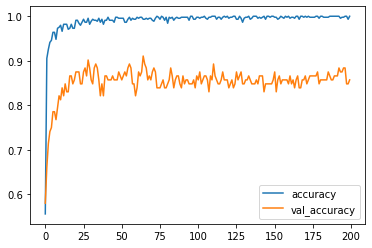

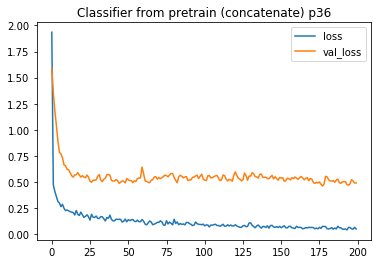

In [27]:
%matplotlib inline
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.title('Classifier from pretrain (concatenate) p36')
plt.show()

In [40]:
# convention
stop_model = load_model('/tf/data/Quan/tf_models/webcam_playaround/amazon_extractor_model.hdf5')
stop_model.evaluate(ttest_features, ttest_num_labels, verbose=1)


239/239 [==============================] - 0s 2ms/step


[0.5047690112720473, 0.8619247078895569]

In [26]:
# convention
stop_model = load_model('/tf/data/Quan/tf_models/webcam_playaround/amazon_ae_model.hdf5')
stop_model.evaluate(test_transform_features, ttest_num_labels, verbose=1)


239/239 [==============================] - 0s 2ms/step


[1.5045636687817434, 0.5941422581672668]

In [32]:
# residual 2
stop_model = load_model('/tf/data/Quan/tf_models/webcam_playaround/amazon_ae_residual_model.hdf5')
stop_model.evaluate(ttest_features, ttest_num_labels, verbose=1)


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


239/239 [==============================] - 1s 2ms/step


[0.6051654424128672, 0.8410041928291321]

In [28]:
# residual without retraining
s_topmodel.evaluate(ttest_features, ttest_num_labels, verbose=1)

239/239 [==============================] - 1s 4ms/step


[4.835845385635248, 0.02092050202190876]

In [24]:
# concat
stop_model = load_model('/tf/data/Quan/tf_models/webcam_phase2/amazon_vae_classifier_scratch_concat_model.hdf5', custom_objects={'latent_dim': (18,18,64)})
stop_model.evaluate(ttest_features, ttest_num_labels, verbose=1)


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


239/239 [==============================] - 0s 2ms/step


[0.5158571648298447, 0.8702929019927979]

In [28]:
# concat with finetune
stop_model = load_model('/tf/data/Quan/tf_models/webcam_phase2/amazon_vae_classifier_concat_model.hdf5', custom_objects={'latent_dim': (18,18,64)})
stop_model.evaluate(ttest_features, ttest_num_labels, verbose=1)


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


239/239 [==============================] - 1s 3ms/step


[0.5919666564614204, 0.8619247078895569]

In [31]:
# feature extractor
stop_model = load_model('/tf/data/Quan/tf_models/webcam_phase2/amazon_extractor_model.hdf5', custom_objects={'latent_dim': (18,18,64)})
stop_model.evaluate(ttest_features, ttest_num_labels, verbose=1)


239/239 [==============================] - 0s 2ms/step


[0.5130208062327557, 0.8702929019927979]

In [ ]:
# retrain source classifier

# Get source classififer (amazon)
s_baseline = load_model('/data/Quan/tf_models/amazon/baseline_model.hdf5')
s_baseline.summary()

input_model = Input(shape=(18,18,736))
x = GlobalAveragePooling2D()(input_model)
x = Dropout(0.3)(x)
x = Dense(31)(x)
x = BatchNormalization()(x)
x = Activation('softmax')(x)

s_topmodel = Model(input_model, x)

for i in range(-3,-1):
#     print(s_topmodel.layers[i+6].name, s_baseline.layers[i].name)
    s_topmodel.layers[i].set_weights(s_baseline.layers[i].get_weights())

s_topmodel.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
s_topmodel.summary()

In [ ]:
s_topmodel.evaluate(test_transform_features, ttest_num_labels, verbose=1)

In [ ]:
mcp = ModelCheckpoint('/data/Quan/tf_models/webcam/amazon_classifier2_model.hdf5', monitor='val_acc', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = s_topmodel.fit(transform_features, t_num_labels, batch_size=32, epochs=100,
               validation_data=(val_transform_features, tval_num_labels), verbose=1, callbacks=[mcp])

with open('/data/Quan/tf_models/webcam/amazon_classifier2_history.hdf5', 'wb') as dt:
    pickle.dump(history, dt)
    
exe_time = time.time() - start

print('exe time: ', exe_time)

In [ ]:
%matplotlib inline
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [ ]:
test_topmodel = load_model('/data/Quan/tf_models/webcam/amazon_classifier2_model.hdf5')
test_topmodel.evaluate(test_transform_features, ttest_num_labels, verbose=1)

In [33]:
baseline_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv0_block0 (Conv2D)           (None, 300, 300, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batchnorm0_block0 (BatchNormali (None, 300, 300, 32) 128         conv0_block0[0][0]               
__________________________________________________________________________________________________
relu0_block0 (Activation)       (None, 300, 300, 32) 0           batchnorm0_block0[0][0]          
____________________________________________________________________________________________